In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sklearn


In [2]:
import kagglehub

if os.path.exists("/home/abhay/.cache/kagglehub/datasets/salvatorerastelli/spotify-and-youtube/versions/2"):
    path = "/home/abhay/.cache/kagglehub/datasets/salvatorerastelli/spotify-and-youtube/versions/2"
else:
    path = kagglehub.dataset_download("salvatorerastelli/spotify-and-youtube")

print("Path to dataset files:", path)

Path to dataset files: /home/abhay/.cache/kagglehub/datasets/salvatorerastelli/spotify-and-youtube/versions/2


/home/abhay/Documents/Repo/abhayma1000/DS-MA4635Final/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sklearn.model_selection import train_test_split

all_data = pd.read_csv(path + "/Spotify_Youtube.csv")

train, val = train_test_split(all_data, test_size=0.3, random_state=42)
val_1, val_2 = train_test_split(val, test_size=0.333, random_state=42)
val_2, test = train_test_split(val_1, test_size=0.5, random_state=42)


In [4]:
train.head(3)

,Unnamed: 0,Artist,Url_spotify,Track,Album,Album_type,Uri,Danceability,Energy,Key,...,Url_youtube,Title,Channel,Views,Likes,Comments,Description,Licensed,official_video,Stream
1452,1452,La Arrolladora Banda El Limón De Rene Camacho,https://open.spotify.com/artist/5bSfBBCxY8QAk4...,Ya Es Muy Tarde,Más Adelante,album,spotify:track:64my6WOkrygcpXKMLxxpi9,0.738,0.588,5.0,...,https://www.youtube.com/watch?v=ObaY-OlG_Bw,La Arrolladora - Ya Es Muy Tarde (Video Oficial),ArrolladoraLimonVEVO,85183929.0,207718.0,3224.0,REMASTERED IN HD!\nMusic video by La Arrollado...,True,True,144770789.0
775,775,Whitney Houston,https://open.spotify.com/artist/6XpaIBNiVzIetE...,My Love Is Your Love,My Love Is Your Love,album,spotify:track:1ckU1EhAO0Nr73QYw24SWJ,0.770,0.475,7.0,...,https://www.youtube.com/watch?v=kxZD0VQvfqU,Whitney Houston - My Love Is Your Love (Offici...,whitneyhoustonVEVO,88471687.0,378367.0,13330.0,Official Video for ”My Love Is Your Love” by W...,True,True,154827777.0
2109,2109,a-ha,https://open.spotify.com/artist/2jzc5TC5TVFLXQ...,Hunting High and Low,Hunting High and Low,album,spotify:track:5tewIdMVsaJWN19ZnmnPNN,0.513,0.676,9.0,...,https://www.youtube.com/watch?v=s6VaeFCxta8,a-ha - Hunting High and Low (Official Video),a-ha,59266514.0,365211.0,17043.0,"Official music video for a-ha - ""Hunting High ...",True,True,64511762.0


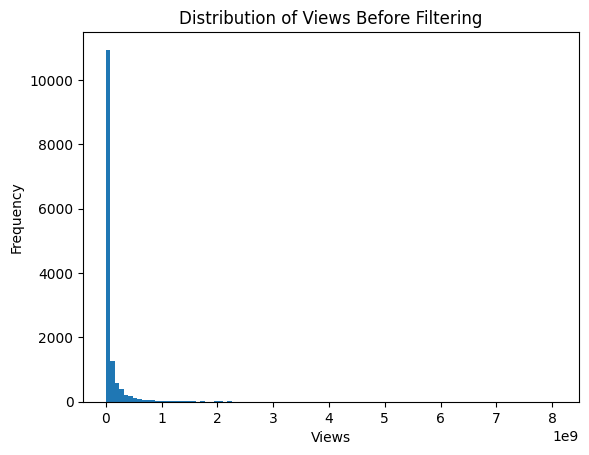

In [5]:
plt.hist(train['Views'], bins=100)
plt.title("Distribution of Views Before Filtering")
plt.xlabel("Views")
plt.ylabel("Frequency")
plt.show()

# Preprocessing

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import copy

def clip(x, mean, std, num_std):
    if x > mean + num_std * std:
        return mean + num_std * std
    elif x < mean - num_std * std:
        return mean - num_std * std
    else:
        return x

def get_train_df(df: pd.DataFrame, numerical_predictors: list, categorical_predictors: list, output: str):
    before_dropped_len = len(df)

    all_cols = numerical_predictors + categorical_predictors + [output]
    all_numerical_cols = numerical_predictors + [output]

    df = df.dropna(subset=all_cols)
    df = df.copy()

    print(f'Dropped {before_dropped_len - len(df)} rows with NaN values. Remaining rows: {len(df)}')

    output_mean = df[output].mean()
    output_std = df[output].std()
    df = df[df[output] <= output_mean + output_std]

    df[output].hist(bins=100)
    plt.title(f"Distribution of {output} after filtering")
    plt.show()

    total_count = 0

    for col in numerical_predictors:
        mean = df[col].mean()
        std = df[col].std()
        count = ((df[col] - mean) / std).abs() > 3
        total_count += count.sum()

        df[col] = df[col].apply(lambda x: clip(x, mean, std, 2))
    
    print(f'Total outliers: {total_count}. Percentage: {total_count / len(df) * 100:.2f}%')
    

    if output == "Views":
        df[output] = df[output].apply(lambda x: np.sqrt(x))
    if 'Duration_ms' in df.columns:
        df['Duration_ms'] = df['Duration_ms'].apply(lambda x: np.sqrt(x))
    # if 'Key' in df.columns:
    #     df['key_angle'] = df['Key'].apply(lambda x: x * 30)
    #     df['key_height'] = df['key_angle'].apply(lambda x: np.sin(np.radians(x)))
    #     df['key_width'] = df['key_angle'].apply(lambda x: np.cos(np.radians(x)))
    #     numerical_predictors.remove("Key")
    #     numerical_predictors.append("key_height")
    #     numerical_predictors.append("key_width")

    df['mean_views'] = df['Artist'].map(df.groupby('Artist')['Views'].mean()).apply(np.sqrt)


    nrows = int(len(numerical_predictors) / 4) + 1
    fig, axes = plt.subplots(nrows, ncols=4, figsize=(60, 20))
    count = 0
    for row in range(nrows):
        for col in range(4):
            if count < len(numerical_predictors):
                axes[row, col].hist(df[numerical_predictors[count]], bins=50)
                axes[row, col].set_title(f"Column {numerical_predictors[count]}")
                count += 1
    if count <= len(numerical_predictors):
        axes[row, col].hist(df[output], bins=50)
    plt.tight_layout()
    plt.show()

    # if "Instrumentalness" in df.columns:
    #     instrumental_mean, instrumental_std = df["Instrumentalness"].mean(), df["Instrumentalness"].std()
    #     df['instrumental_binary'] = df["Instrumentalness"].apply(lambda x: 1 if x > instrumental_mean + 1 * instrumental_std or x < instrumental_mean - 1 * instrumental_std else 0)

    #     numerical_predictors.remove("Instrumentalness")
    #     numerical_predictors.append("instrumental_binary")
    print("Numerical predictors train: ", numerical_predictors)

    x_scaler = None
    # x_scaler = StandardScaler()
    # x_scaler.fit(df[numerical_predictors])
    # df[numerical_predictors] = x_scaler.transform(df[numerical_predictors])

    x = df[numerical_predictors].to_numpy()

    nrows = int(x.shape[1] / 4) + 1
    fig, axes = plt.subplots(nrows, ncols=4, figsize=(60, 20))
    count = 0
    for row in range(nrows):
        for col in range(4):
            if count < x.shape[1]:
                axes[row, col].hist(x[:, count], bins=50)
                axes[row, col].set_title(f"Column {col}")
                count += 1
    # if count <= len(numerical_predictors):
    #     axes[row, col].hist(df[output], bins=50)
    plt.tight_layout()
    plt.show()

    y = df[output].to_numpy().ravel() # Use ravel() to ensure y is 1D

    pca = None
    # pca = PCA(n_components=1)
    # pca.fit(x)
    # x = pca.transform(x)
    # explained_variance_ratio = pca.explained_variance_ratio_
    # plt.figure(figsize=(10, 6))
    # plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
    # plt.title('Scree Plot')
    # plt.xlabel('Principal Component')
    # plt.ylabel('Explained Variance Ratio')
    # plt.xticks(range(1, len(explained_variance_ratio) + 1))
    # plt.grid(True)
    # plt.show()
    # print("PCA explained variance ratio:", explained_variance_ratio)
    # print("PCA components shape:", pca.components_.shape)

    return x, y, x_scaler, df['mean_views'], pca


def get_val_df(df: pd.DataFrame, numerical_predictors: list, categorical_predictors: list, output: str, x_scaler=None, mean_views=None, pca=None):
    all_cols = numerical_predictors + categorical_predictors + [output]
    df = df.dropna(subset=all_cols).copy()

    for col in numerical_predictors:
        mean = df[col].mean()
        std = df[col].std()
        df[col] = df[col].apply(lambda x: clip(x, mean, std, 2))

    if output == "Views":
        df[output] = df[output].apply(lambda x: np.sqrt(x))
    if 'Duration_ms' in df.columns:
        df['Duration_ms'] = df['Duration_ms'].apply(lambda x: np.sqrt(x))
    # if 'Key' in df.columns:
    #     df['key_angle'] = df['Key'].apply(lambda x: x * 30)
    #     df['key_height'] = df['key_angle'].apply(lambda x: np.sin(np.radians(x)))
    #     df['key_width'] = df['key_angle'].apply(lambda x: np.cos(np.radians(x)))
    #     numerical_predictors.remove("Key")
    #     numerical_predictors.append("key_height")
    #     numerical_predictors.append("key_width")

    if mean_views is not None:
        df['mean_views'] = df['Artist'].map(mean_views).apply(np.sqrt)

    feature_list = list(numerical_predictors)
    # if "Instrumentalness" in df.columns and "Instrumentalness" in feature_list:
    #     instrumental_mean, instrumental_std = df["Instrumentalness"].mean(), df["Instrumentalness"].std()
    #     df['instrumental_binary'] = df["Instrumentalness"].apply(
    #         lambda x: 1 if x > instrumental_mean + 1 * instrumental_std or x < instrumental_mean - 1 * instrumental_std else 0)
    #     feature_list.remove("Instrumentalness")
    #     feature_list.append("instrumental_binary")

    # if x_scaler is not None:
    #     df[feature_list] = x_scaler.transform(df[feature_list])

    x = df[feature_list].to_numpy()

    # if pca is not None:
    #     x = pca.transform(x)

    y = df[output].to_numpy().ravel()
    return x, y

In [7]:
cols_to_use = [
    'Danceability',
    'Energy',
    # 'Key',
    'Loudness',
    'Speechiness',
    'Acousticness',
    'Instrumentalness',
    'Liveness', # like energy
    'Valence',
    'Tempo',
    'Duration_ms',
]

train[cols_to_use].describe()

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms
count,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,1.450100e+04
mean,0.621221,0.635469,-7.666676,0.097304,0.290354,0.055523,0.193515,0.528996,120.647340,2.237756e+05
std,0.165229,0.213997,4.649465,0.113346,0.285238,0.192747,0.168227,0.245692,29.644243,1.125104e+05
min,0.000000,0.000055,-44.761000,0.000000,0.000001,0.000000,0.014500,0.000000,0.000000,3.098500e+04
25%,0.519000,0.506000,-8.822000,0.036000,0.044800,0.000000,0.094200,0.339000,96.955000,1.801600e+05
50%,0.639000,0.666000,-6.519000,0.051200,0.192000,0.000002,0.125000,0.535000,119.971000,2.133330e+05
75%,0.742000,0.798000,-4.917000,0.104000,0.475000,0.000484,0.237000,0.726000,139.949000,2.522400e+05
max,0.975000,1.000000,0.920000,0.964000,0.996000,1.000000,0.997000,0.993000,236.059000,4.581483e+06


Dropped 325 rows with NaN values. Remaining rows: 14177


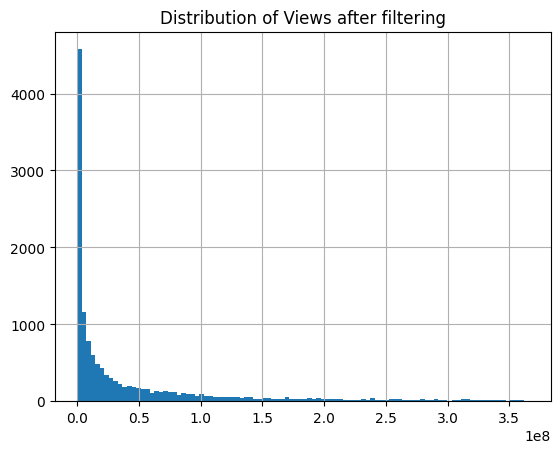

Total outliers: 1743. Percentage: 13.09%


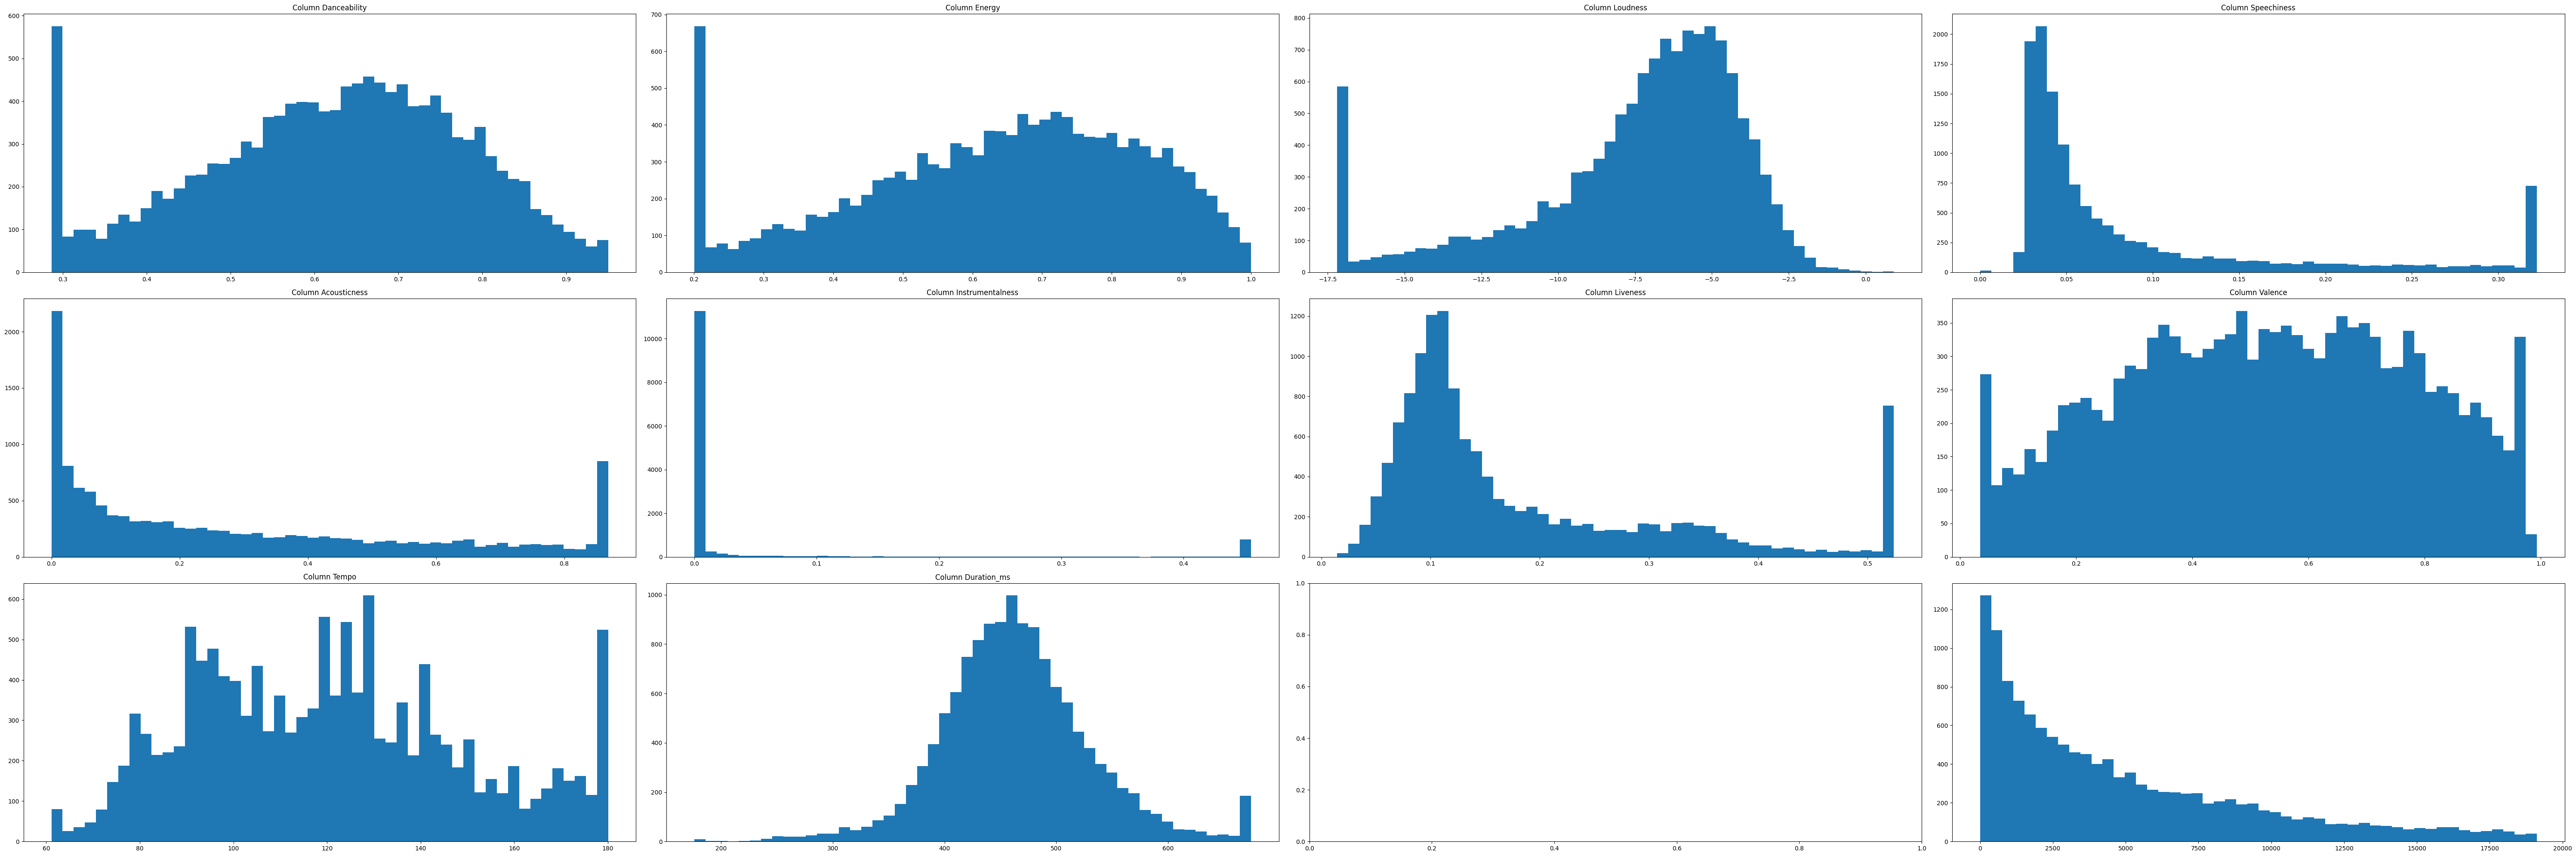

Numerical predictors train:  ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms']


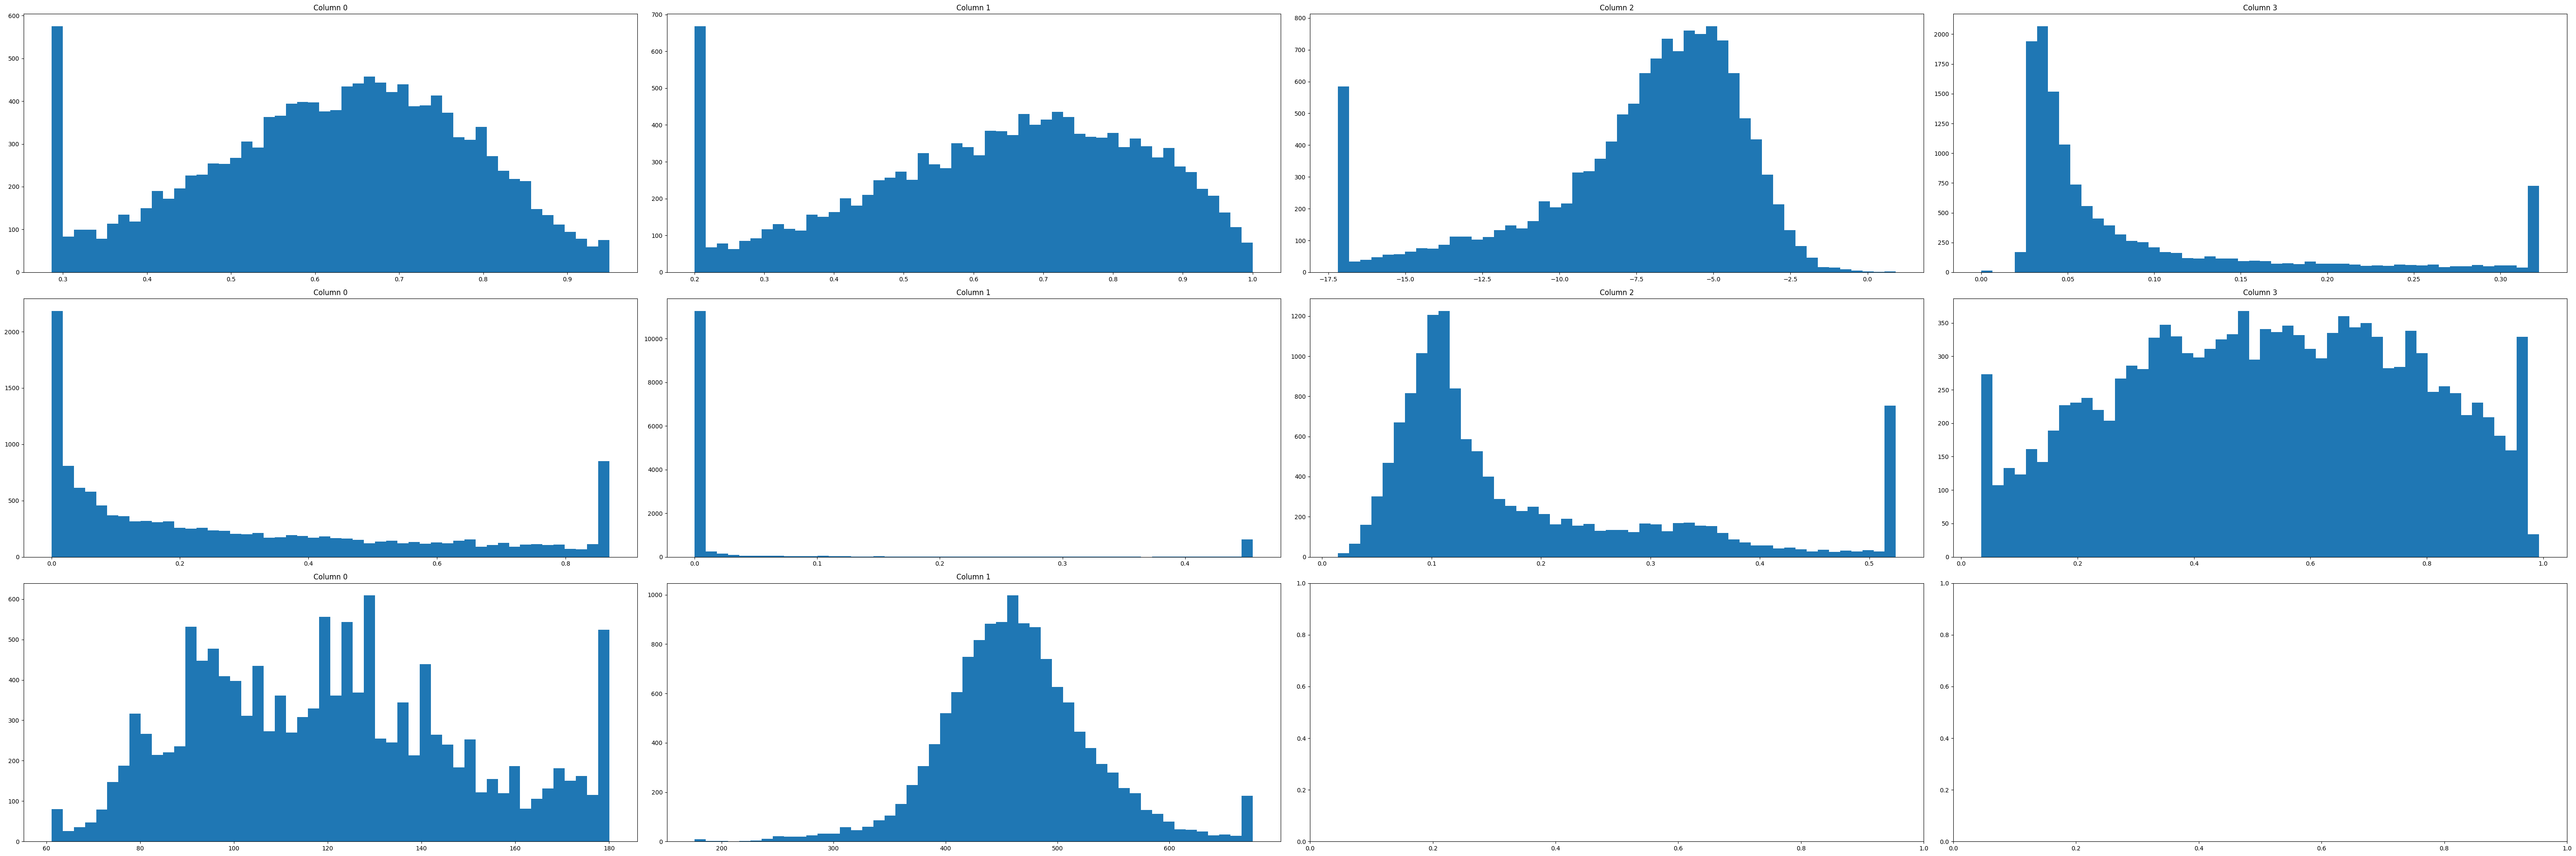

In [8]:
val_1_cols_to_use = copy.deepcopy(cols_to_use)
val_2_cols_to_use = copy.deepcopy(cols_to_use)
test_cols_to_use = copy.deepcopy(cols_to_use)
train_x_np, train_y_np, x_scaler, mean_views, pca = get_train_df(train, cols_to_use, [], 'Views')

val_1_x_np, val_1_y_np = get_val_df(val_1, val_1_cols_to_use, [], 'Views', x_scaler, mean_views, pca)
val_2_x_np, val_2_y_np = get_val_df(val_2, val_2_cols_to_use, [], 'Views', x_scaler, mean_views, pca)
test_x_np, test_y_np = get_val_df(test, test_cols_to_use, [], 'Views', x_scaler, mean_views, pca)

In [9]:
# If we used pca, would plot the different components

# nrows = int(train_x_np.shape[1] / 4) + 1
# fig, axes = plt.subplots(nrows, ncols=4, figsize=(60, 20))
# count = 0
# for row in range(nrows):
#     for col in range(4):
#         if count < train_x_np.shape[1]:
#             axes[row, col].hist(train_x_np[:, count], bins=50)
#             axes[row, col].set_title(f"Column {col}")
#             count += 1
# # if count <= len(numerical_predictors):
# #     axes[row, col].hist(df[output], bins=50)
# plt.tight_layout()
# plt.show()

# Models

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor


linear_model = LinearRegression().fit(train_x_np, train_y_np)

print("Model Coefficients:", linear_model.coef_)


poly = PolynomialFeatures(degree=3)
poly.fit(train_x_np)
train_x_poly = poly.transform(train_x_np)
poly_model = LinearRegression().fit(train_x_poly, train_y_np)
print("Polynomial Model Coefficients:", poly_model.coef_)


# Create and fit the Random Forest Regressor
tree = RandomForestRegressor(n_estimators=500)
tree.fit(train_x_np, train_y_np)

print("Random Forest Feature Importances:", tree.feature_importances_)


# print(f"Model score on train data: {model.score(train_x_np, train_y_np)}")

Model Coefficients: [ 2313.70766368 -1552.51391529   296.45407638 -2193.73975454
  -132.09262309 -2630.81917178  -185.212826    -362.91365208
     3.98670305    10.06035232]
Polynomial Model Coefficients: [ 3.32360113e-02  2.28546326e+04  2.15200412e+04 -4.01832244e+03
  9.44384982e+04  1.60834885e+04 -8.04834681e+04  2.70292878e+04
  3.68952478e+03 -5.23467771e+01  1.74781172e+02  5.31039662e+04
  2.70657628e+03  6.01130873e+02 -1.33406279e+05 -1.77322659e+04
  2.41619580e+04 -2.77294884e+04 -1.47490320e+04 -2.08153971e+02
 -1.22655851e+02  3.35992030e+03  3.58517281e+02 -5.19571568e+04
  1.32564305e+03  2.44989144e+04 -7.68096646e+04 -4.37942746e+04
  3.13294367e+02 -1.33311874e+02 -9.83793864e+01  2.81035336e+03
  1.17849326e+03 -2.37729427e+03  2.60844636e+03  1.47209381e+03
 -2.69858868e+00  1.10825580e+01 -1.38983566e+05 -3.43869338e+04
 -9.36682732e+04 -2.54617939e+04 -1.96557742e+04 -1.50165120e+02
  1.11623946e+02  1.56338774e+04  2.34479175e+04 -2.95231344e+04
 -4.25819783e+0

# Evaluation on Val data

Linear Regression Mean Squared Error (Scaled): 51949089.946096316
Linear Regression R^2 Score (Scaled): 0.03264218304911415


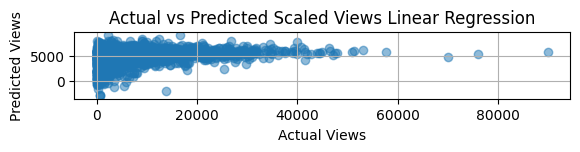

Polynomial Regression Mean Squared Error (Scaled): 50888077.34002383
Polynomial Regression R^2 Score (Scaled): 0.05239958090598984


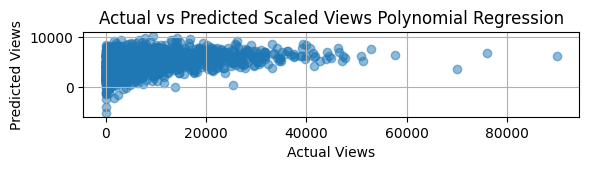

Random Forest Regression Mean Squared Error (Scaled): 48833103.901808575
Random Forest Regression R^2 Score (Scaled): 0.09066578770858558


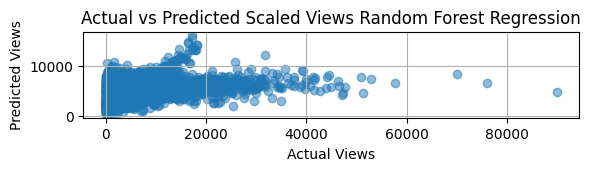

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

def print_scores(y_actual, y_pred, name=str):
    mse = mean_squared_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    print(f"{name} Mean Squared Error (Scaled): {mse}")
    print(f"{name} R^2 Score (Scaled): {r2}")

    fig, ax = plt.subplots()
    ax.scatter(y_actual, y_pred, alpha=0.5)
    # ax.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    ax.set_xlabel("Actual Views")
    ax.set_ylabel("Predicted Views")
    ax.set_title(f"Actual vs Predicted Scaled Views {name}")
    ax.set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

print_scores(val_1_y_np, linear_model.predict(val_1_x_np), "Linear Regression")
print_scores(val_1_y_np, poly_model.predict(poly.transform(val_1_x_np)), "Polynomial Regression")
print_scores(val_1_y_np, tree.predict(val_1_x_np), "Random Forest Regression")



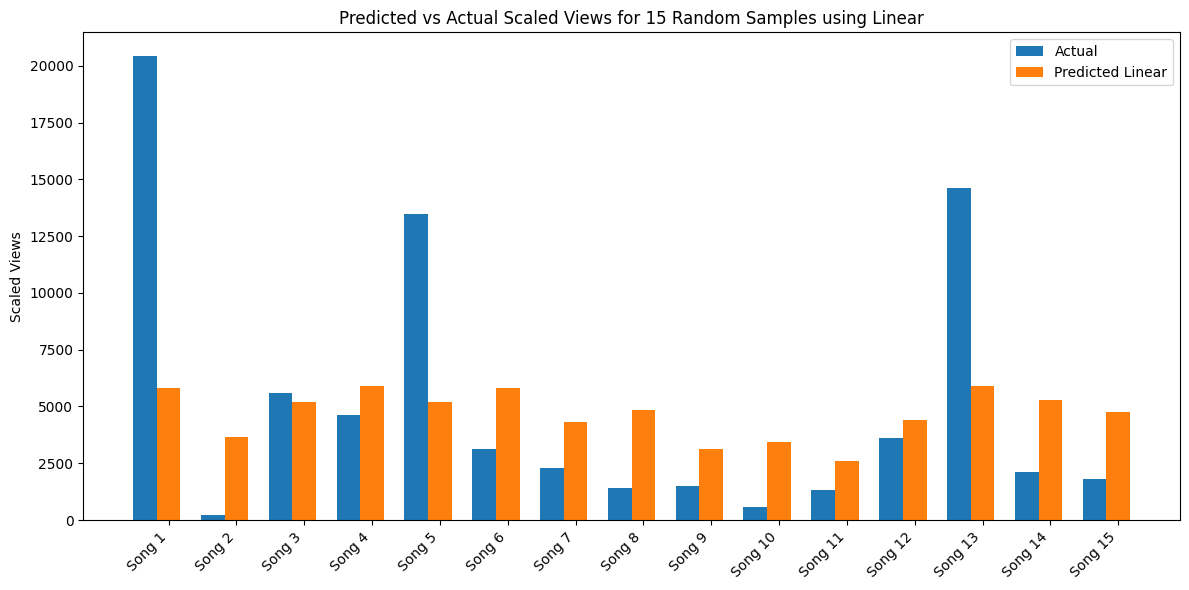

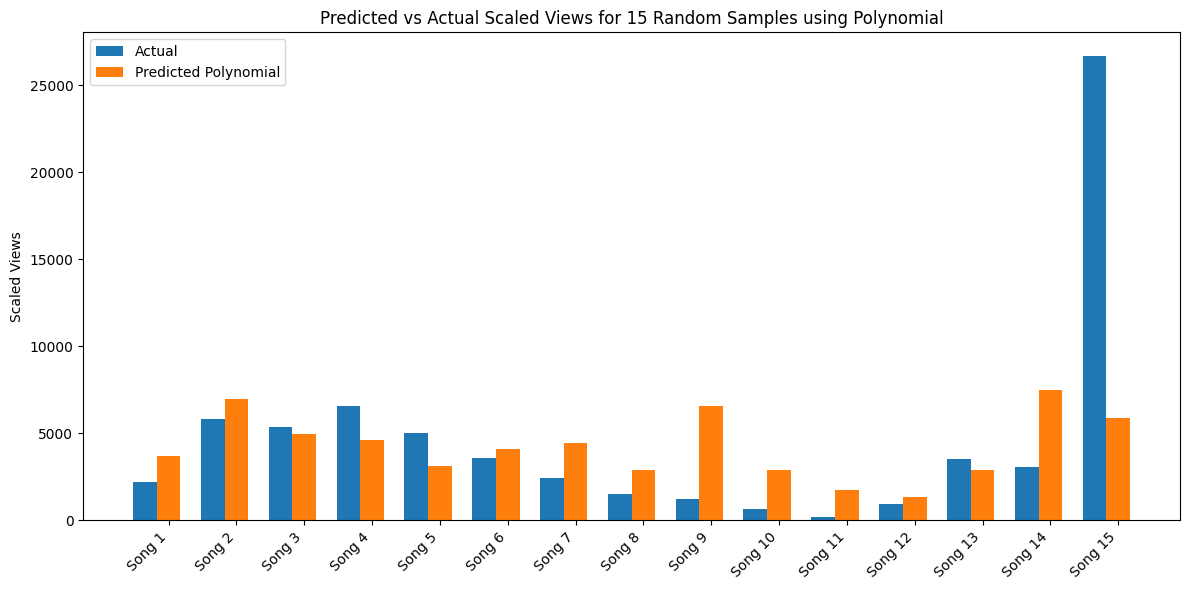

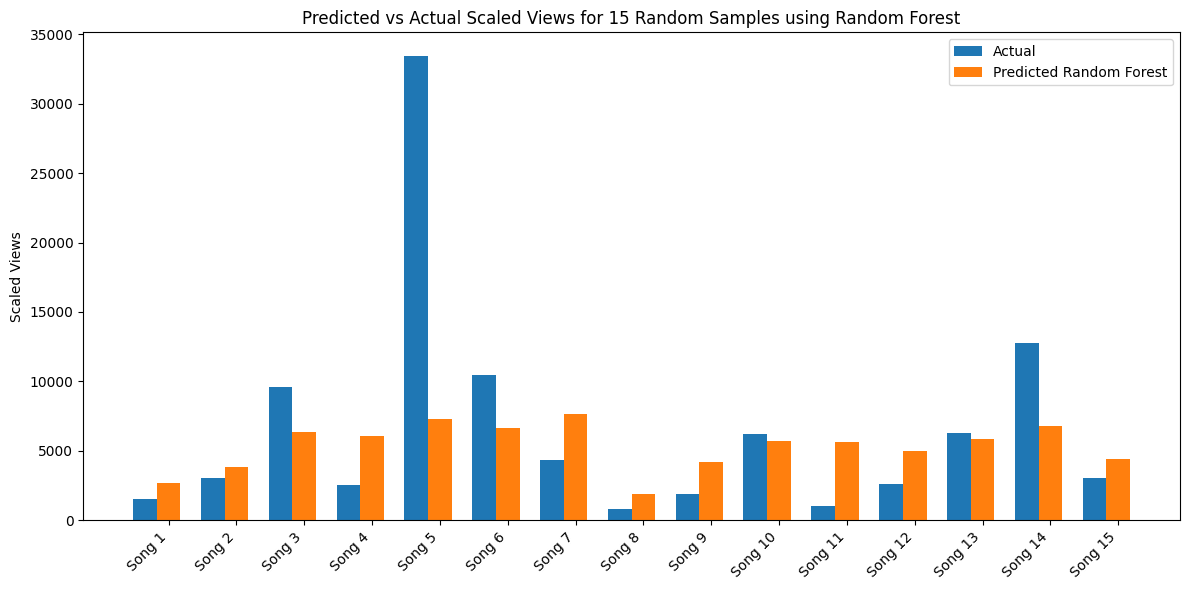

In [12]:
import random as rd

def plot_predications_vs_actual(y_actual, y_pred, number_plotting: int, name: str):
    indices = rd.sample(range(len(y_pred)), number_plotting) # Use sample to avoid duplicates

    w, x = 0.35, np.arange(number_plotting)

    fig, ax = plt.subplots(figsize=(12, 6))

    y_pred_sampled = y_pred[indices]
    y_actual_sampled = y_actual[indices]

    ax.bar(x - w, y_actual_sampled.squeeze(), width=w, label='Actual')
    ax.bar(x, y_pred_sampled.squeeze(), width=w, label=f'Predicted {name}')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Song {i+1}' for i in range(number_plotting)])
    ax.set_ylabel("Scaled Views")
    ax.set_title(f"Predicted vs Actual Scaled Views for {number_plotting} Random Samples using {name}")
    ax.legend()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


number_plotting = 15
plot_predications_vs_actual(val_1_y_np, linear_model.predict(val_1_x_np), number_plotting, "Linear")
plot_predications_vs_actual(val_1_y_np, poly_model.predict(poly.transform(val_1_x_np)), number_plotting, "Polynomial")
plot_predications_vs_actual(val_1_y_np, tree.predict(val_1_x_np), number_plotting, "Random Forest")

# Final use of test data

Tree Mean Squared Error (Scaled): 47703545.60707817
Tree R^2 Score (Scaled): 0.09219428520296002


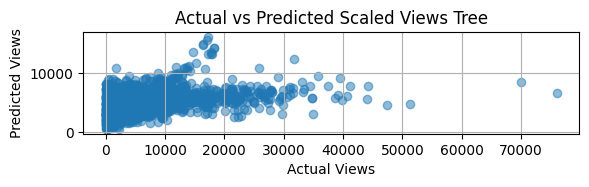

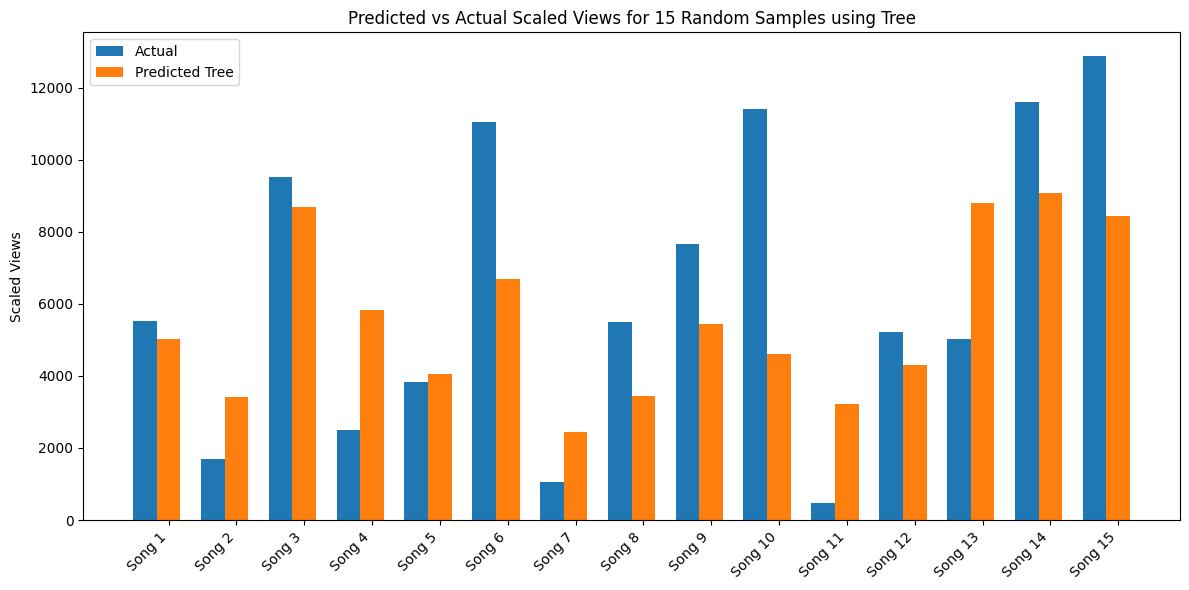

In [13]:
print_scores(test_y_np, tree.predict(test_x_np), "Tree")
plot_predications_vs_actual(test_y_np, tree.predict(test_x_np), number_plotting, "Tree")

# Useful tree plots

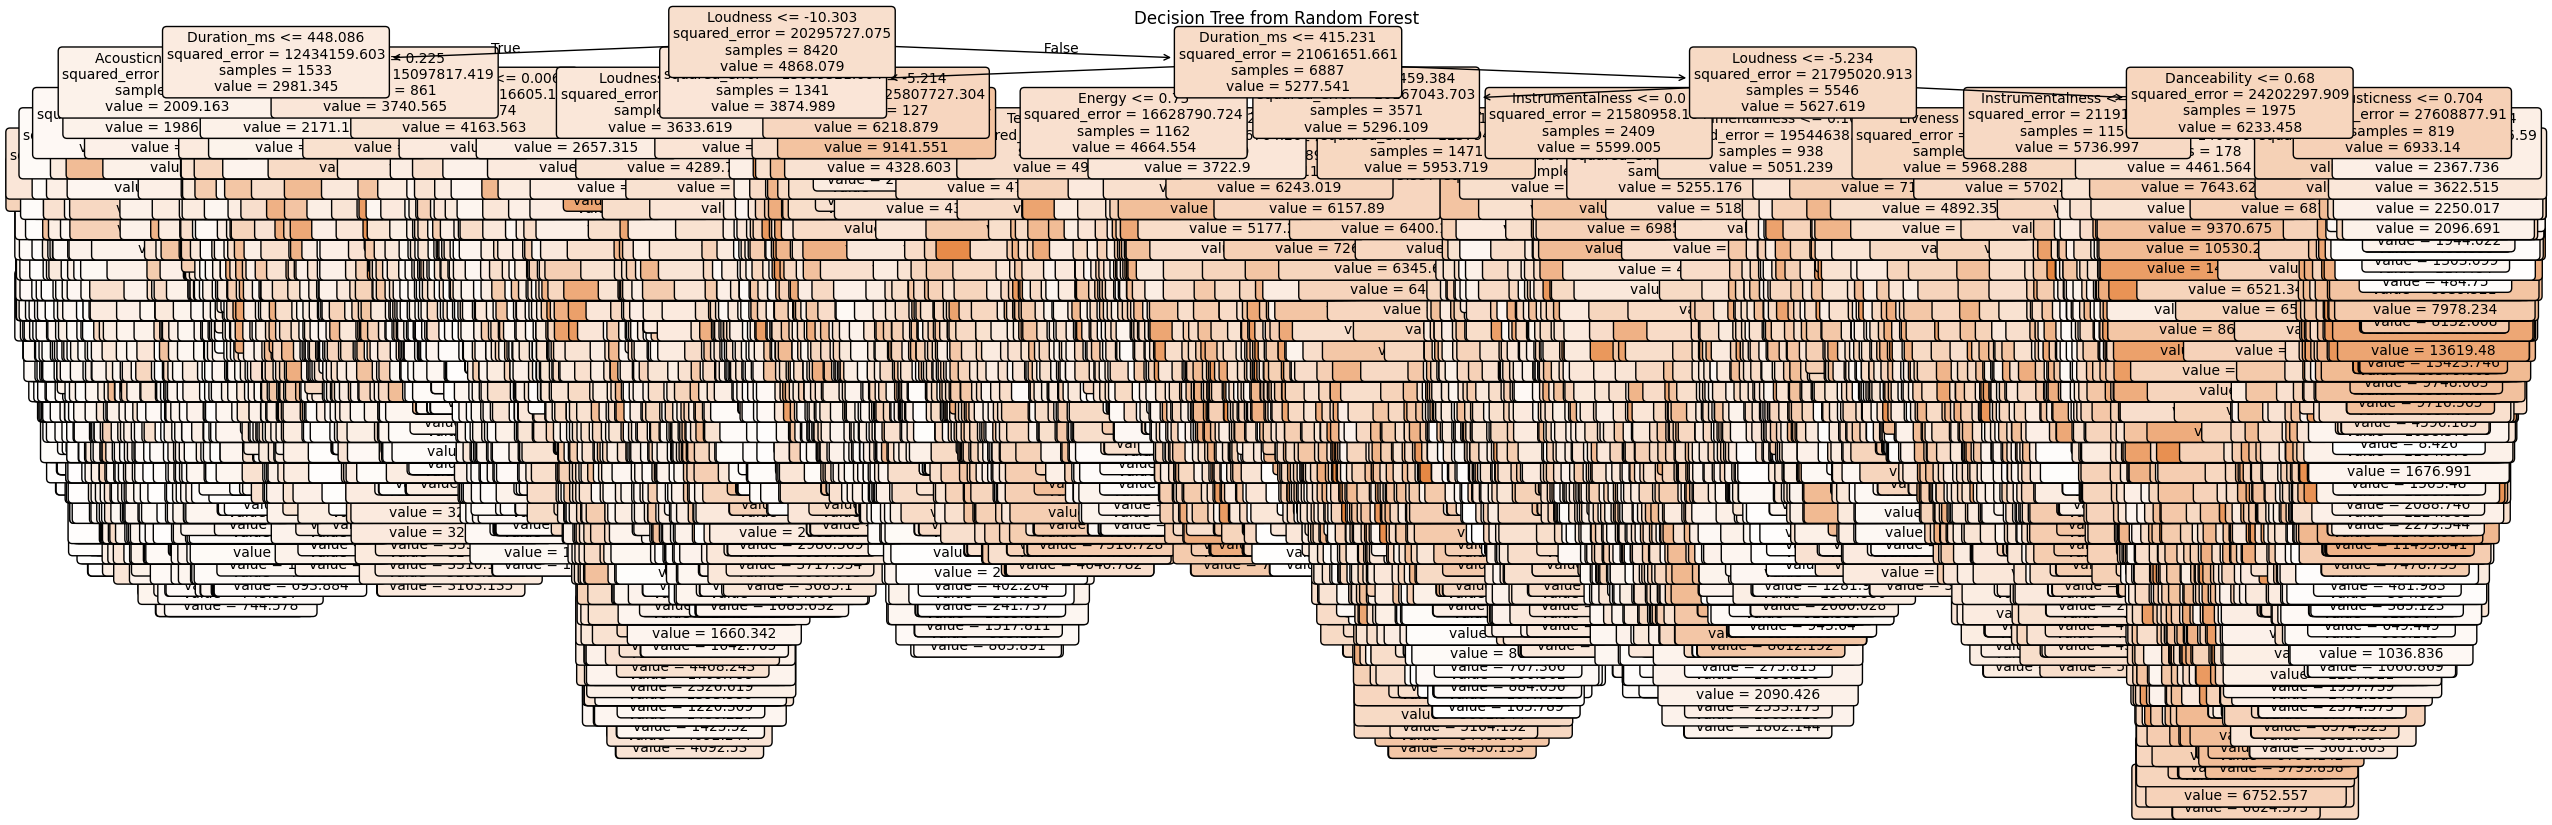

In [14]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree_to_plot = tree.estimators_[0]

# Plot the decision tree
plt.figure(figsize=(30, 10))
plot_tree(tree_to_plot, feature_names=cols_to_use, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()